[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NLTGit/OpenNightLights-colab-mirror/blob/master/onl/tutorials/mod4_1_time_series_charts.ipynb)

# Time Series Charts

In the last module we worked through some basic operations and visualized the results as map layers. For analytical work, it is also useful to plot the data in charts. For understanding temporal dynamics, which is a common desire when working with remote sensing, you will want a line graph that shows quantities of a variable over time, commonly known as a time series graph.

### Quick caveat on charts with the Earth Engine Python API
Google Earth Engine (GEE) provides a User-Interface (UI) <a href="https://developers.google.com/earth-engine/guides/charts">module for creating charts</a> directly in the Editor. It's built on the <a href="https://developers.google.com/chart/interactive/docs/reference">Google Visualization API</a> if you're familiar with that in other Google products.

Unfortunately, the UI module is not availabe through the Python API, including the `ee` library, but we'll introduce some Python-centric approaches to extracting and visualizing data. 

As an additional constraint, plotting data in this manner requires you to actually extract data from its location on Google servers ("in the cloud") to your local machine for visualization. Just as with any data extraction, there are constraints to how much data you can actually move, so it will be prohibitive to plot very large scenes. 

This is a limitation of using the Python API, but for our tutorial, we'll make sure you're familiar with the basic concepts you can use to advance to working with larger, more complex data. If you find you are hitting limits, you will want to look into using the native GEE Editor (i.e. conducting your entire workflow within the cloud) -- as mentioned, <a href="https://developers.google.com/earth-engine/apidocs">it has comprehensive documentation</a>. Or you might consider investing in resources, time, and training to extract and process this data yourself. This is becoming easier to do and the full world of remote sensing analysis awaits you! But is out of the scope of this tutorial.

In this exercise, we will create a simple time series for VIIRS-DNB values at a specific location. We'll also build on what we've learned reduce data for a region, such as in {doc}`mod3_4_cell_statistics_band_math`, to create time series for an entire region.

**Our tasks in this exercise:**
1. Extracting VIIRS time series data and converting to a pandas dataframe
2. Create a 2014-2020 time series graph from VIIRS-DNB data for a point in Seoul, South Korea
2. Create a 2014-2020 time series graph for Sum Of Lights (SOL) for South Korea

## Extract time series data and convert to pandas dataframe

Those familiar with Python know that `pandas` is an indespensible library, a package data analysis built on another indispensible package, `numpy`. We will extract the data from our raster file of VIIRS-DNB radiance and convert it into a pandas dataframe in our local computing space so that we can use a plot libraries, `matplotlib` and `seaborn` to make our line graph.

First we define our point of interest: the location of Seoul Olympic Stadium (a.k.a. Jamsil Olympic Stadium). Technically we'll pick a lat/lon coordinate in the stadium and create a 500m buffer around it.

Then we'll grab a collection of VIIRS-DNB monthly composites from January 2014 to May 2020.

In [4]:
# !pip install matplotlib seaborn==0.11.0

In [5]:
import geemap, ee
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# identify a 500 meter buffer around our Point Of Interest (POI)
poi = ee.Geometry.Point(127.072483, 37.515817).buffer(500)

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01','2020-5-31')

### Extracting all image values in the collection

To make a time series, we need to get all the values in our collection using the `map` function. We'll create a custom function in Python that takes a single image as an input and reduces the data in a given region (our point of interest in this case).

We'll get the mean of the pixels in our region and set the scale to 30. We'll use the `avg_rad` band.

We'll then need to set this reduced info as a property (we'll call it "mean") in our image so that the output of our function is to get the mean radiance of a particular region, and add this as a property on our image along with the date.

In [6]:
def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

We map this function to every image in our collection to get a new ImageCollection, but now each image has the mean value for the region of interest and the date. These are the data we'll make our time series out of.

In [7]:
poi_reduced_imgs = viirs.map(poi_mean)

To convert to a pandas dataframe, we dont want an ImageCollection; however, so we will reduce our images to a list of lists:
- for each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
- each of these lists are themselves elements in our outer list, which is what we'll convert to a dataframe

In [8]:
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

This nested list can be turned into a dataframe using the `.DataFrame` constructor. We'll name the columns, "date" and "mean".

In [9]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

df

,date,mean
0,2014-01-01T00:00:00,61.927905
1,2014-02-01T00:00:00,51.591837
2,2014-03-01T00:00:00,51.378309
3,2014-04-01T00:00:00,59.228776
4,2014-05-01T00:00:00,63.510432
...,...,...
72,2020-01-01T00:00:00,44.474762
73,2020-02-01T00:00:00,38.256775
74,2020-03-01T00:00:00,46.065028
75,2020-04-01T00:00:00,45.411734


Great! Now we have a dataframe with each observation (month) as a row and it has the timestamp and mean values.

A reason pandas is so powerful is that it has built-ins, like a method to convert our string timestamp into a native timestamp data type.

We will also set our date column to be our index. Doing these things allows our `.plot` library to automatically convert the dates into nice readable dates on our axis.

In [10]:
df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')

df

,mean
date,
2014-01-01,61.927905
2014-02-01,51.591837
2014-03-01,51.378309
2014-04-01,59.228776
2014-05-01,63.510432
...,...
2020-01-01,44.474762
2020-02-01,38.256775
2020-03-01,46.065028


OK! Now we're ready to make a plot.

## Create a time series graph for VIIRS-DNB from Jan 2014 to May 2020 for Seoul Olympic Stadium

We'll create a time series, but first let's get a look at where we're analyzing.

In [11]:
koreaMap = geemap.Map()
koreaMap.centerObject(poi, zoom=13)
koreaMap.add_basemap("SATELLITE")
koreaMap.addLayer(poi, {}, "Seoul Olympic Stadium")
koreaMap.addLayerControl()
koreaMap

Map(center=[37.5158175129507, 127.07248301794745], controls=(WidgetControl(options=['position'], widget=HBox(c…

Our buffer encompasses almost the entire complex. Ok, let's look at times series graphs...

Pandas dataframes integrates nicely with our plotting libraries. We'll use `seaborn` to make a simple time series line plot.

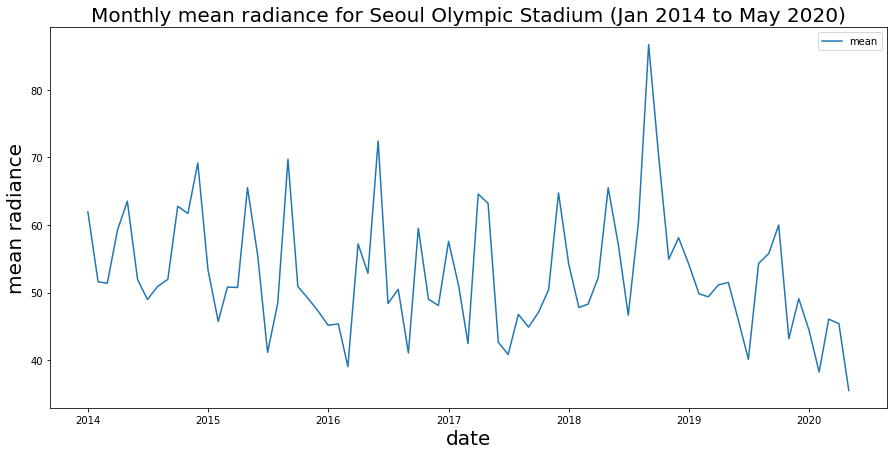

In [12]:
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# we'll create the plot by setting our dataframe to the data argument
sns.lineplot(data=df, ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('Monthly mean radiance for Seoul Olympic Stadium (Jan 2014 to May 2020)',fontsize=20);

**Brief observations:** we see some strong seasonal patterns here (peaks and values), which is perhaps not too surprising for a sports stadium. We also see a spike in late 2018 as well as the drop-off in early 2020 that is very likely an indication of COVID-19 impacts.

Just out of curiousity...what is that spike? With dataframes we can easily find the date of that peak using the `.idxmax()` method to get the index (which is the month) of our maximum value.

In [13]:
df.idxmax()

mean   2018-09-01
dtype: datetime64[ns]

Hm, what was happening in September 2018? As it happens, 2018 is the 30th anniversary of the Seoul Olympics...perhaps there were a lot of events and concerts? 

With our time series data, we can also smooth our time series (this is again, easy with Pandas. We'll get a moving avg of 12 months to smooth our data out and see overall trends):

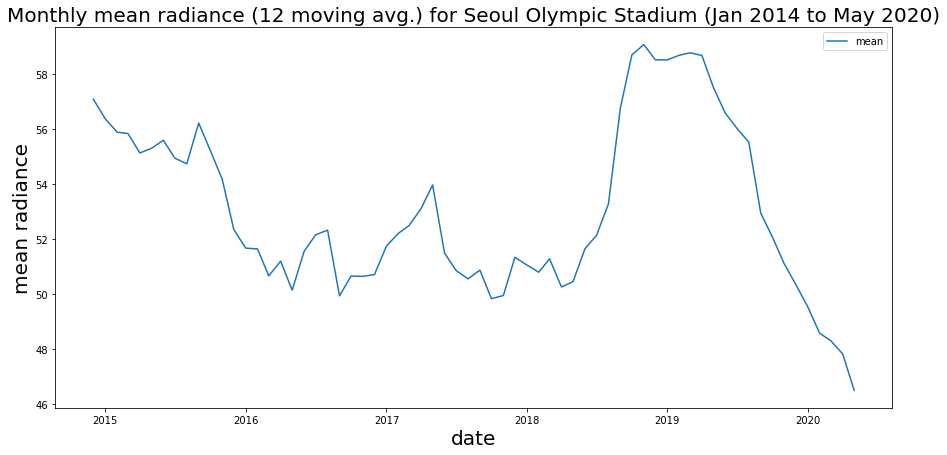

In [14]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving averate using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=df.rolling(window).mean(), ax=ax)

# we'll set the labels and title
ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean radiance ({window} moving avg.) for Seoul Olympic Stadium (Jan 2014 to May 2020)',fontsize=20);

We can see an overall trend that does seem to be decreasing, aside from our 2018 spike.

These's a lot you can do for time series analysis, including a Fourier Transform to identify strong cycles or even ARIMA models or more complex models to forecast trends. We wont get into that here, but hopefully you can see the power of remote sensing to support time series analysis.

## Time series using Sum Of Lights from Jan 2014 to May 2020 for South Korea

Recall in {doc}`mod4_5_vector_and_raster_data` that we are cautious about calculating SOL for comparing regions since the scale of the reducer function can profoundly affect the aggregation; however, here we're comparing the same region over time, so we're comfortable using SOL.

We will use the shapefile for South Korea in GEE and instead of using our mean reducer on a point of interest, we'll apply a sum reducer on all of South Korea. We'll adjust the scale to 500 meters and we'll have to set the `maxPixels` threshold to 1 billion.

In [15]:
# get South Korea national boundary geometry
sokorea = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Republic of Korea')).first())

# revise our reducer function to be to get SOL for South Korea
def get_sokorea_sol(img):
    sol = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=sokorea.geometry(), scale=500, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('SOL',sol)

At this point, the steps to map our reducer to our collection, reduce this further to nested lists, convert to a dataframe, and plot are the same, however!

Getting the sum (even at 500m scale) will probably take a few moments...even with the infrastructure of Google at work.

In [16]:
# reduce collection
sokorea_sol = viirs.map(get_sokorea_sol)

# get lists
nested_list = sokorea_sol.reduceColumns(ee.Reducer.toList(2), ['date','SOL']).values().get(0)

# convert to dataframe
soldf = pd.DataFrame(nested_list.getInfo(), columns=['date','SOL'])
soldf['date'] = pd.to_datetime(soldf['date'])
soldf = soldf.set_index('date')

Let's get a look at nighttime lights for South Korea (we'll look at the median for our entire time period for visualization purposes...)

In [17]:
koreaMap2 = geemap.Map()
koreaMap2.centerObject(sokorea, zoom=7)
koreaMap2.add_basemap("SATELLITE")
koreaMap2.addLayer(sokorea, {}, "South Korea")
koreaMap2.addLayer(viirs.select('avg_rad').median(), {'min':0,'max':10}, "VIIRS 2014-2020 mean")
koreaMap2.addLayerControl()
koreaMap2

Map(center=[36.34449219000825, 127.80177597242078], controls=(WidgetControl(options=['position'], widget=HBox(…

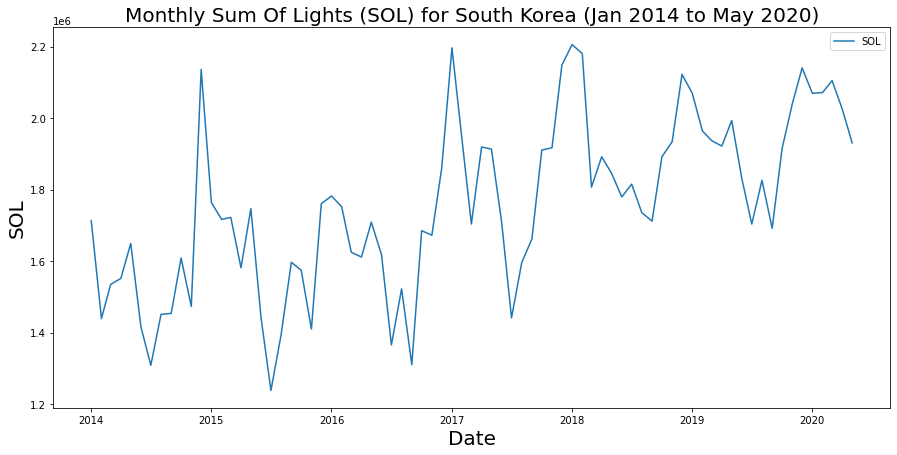

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=soldf, ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Monthly Sum Of Lights (SOL) for South Korea (Jan 2014 to May 2020)',fontsize=20);

Is the drop in 2020 an indication of lower activity or is it following a cycle? Further time series analysis, such as autocorrelation, leveraging historical data will be needed. It's also worth considering a metric rather than SOL and perhaps scaling our data against area or disaggregating according to urban vs rural, etc.

**On your own**: could you use what we learned with {doc}`mod3_3_conditional_operations` to split the data into separate "high" and "low" radiance time series to potential assess time series in both groups?

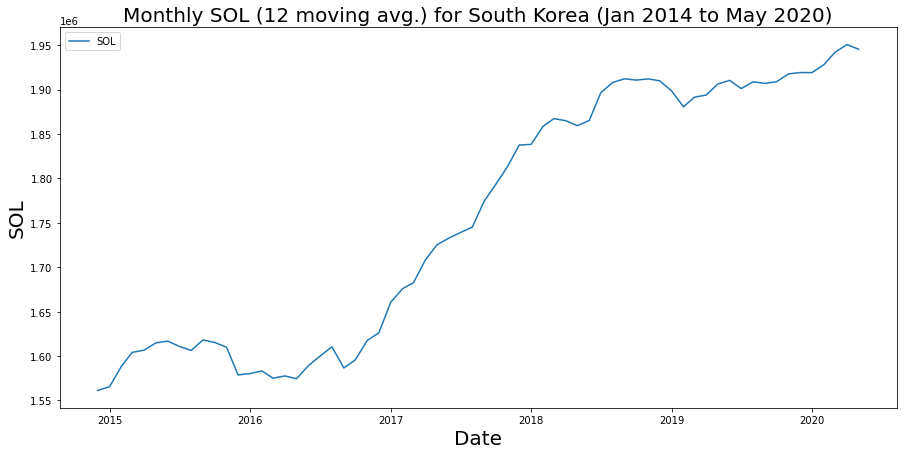

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
window=12
sns.lineplot(data=soldf.rolling(window).mean(), ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Monthly SOL ({window} moving avg.) for South Korea (Jan 2014 to May 2020)',fontsize=20);

Smoothing out our time series, we see quite an upward trend. What is interesting is we do not see a dramatic drop in 2020 in our aggregated metric. We've talked about cleaning and scaling data -- and that's something we'd probably want to do here before drawing strong inferences, but again getting data from a series of raster files to a dataframe you can plot and analze is just the start!

## References:
```{bibliography} ../references.bib
:filter: docname in docnames
```